In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizerFast, RobertaModel, Trainer, TrainingArguments

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# Initialize pretrained RoBERTa model and RoBERTa tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', truncation = True)

# Initialize dataset
data = pd.read_csv('drive/MyDrive/Colab Notebooks/Sentiment_IMDB_Dataset.csv')
data['sentiment'] = data['sentiment'].map({'positive':1, 'negative':0})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [3]:
# Build custom dataset to feed RoBERTa
class IMDB_Dataset(Dataset):
  def __init__(self, data, tokenizer, max_len):
    self.data = data
    self.reviews = self.data.review
    self.sentiments = self.data.sentiment
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    # Load the review
    text = str(self.reviews[index])

    # Tokenize text and prepare it for model input
    inputs = self.tokenizer.encode_plus(text, None,
                                        truncation=True, padding='max_length',
                                        max_length=self.max_len,
                                        add_special_tokens=True, return_token_type_ids=True)

    ## Prepare data format as expected by RoBERTa model
    # mapping of words into integers according to tokenizer's vocabulary
    ids = inputs['input_ids']

    # Binary mask indicating which tokens are actual input tokens and which are padding tokens
    # The attention mask is used by the model to avoid processing padding tokens, thus saving computational resources and improving performance.
    attention_mask = inputs['attention_mask']

    # IDs are used to distinguish between different sequences in tasks where multiple sequences are
    # provided to the model (e.g., question-answering tasks where there is a context and a question)
    token_type_ids = inputs['token_type_ids']

    return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(attention_mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.sentiments[index], dtype=torch.float)
        }


In [4]:
# Split data between training and testing
training_data = data.sample( frac=0.8 )
testing_data = data.drop(training_data.index).reset_index(drop=True)
training_data = training_data.reset_index(drop=True)

In [5]:
# Save data into custom dataset class
training_set = IMDB_Dataset(data=training_data, tokenizer=tokenizer, max_len=512)
testing_set = IMDB_Dataset(data=testing_data, tokenizer=tokenizer, max_len=512)

print(f"Training data's shape{training_data.shape} - Testing data's shape{testing_data.shape}")

# Initialize data loaders
training_loader = DataLoader(training_set, batch_size=18, shuffle=True)
testing_loader = DataLoader(testing_set, batch_size=18, shuffle=True)

Training data's shape(40000, 2) - Testing data's shape(10000, 2)


In [6]:
# Build Model
class RoBERTa_GRU(torch.nn.Module):
  def __init__(self):
    super(RoBERTa_GRU, self).__init__()

    # Initialize the layers that are needed
    self.RoBERTa = RobertaModel.from_pretrained('roberta-base')
    self.gru = torch.nn.GRU( input_size = 768, hidden_size = 256 )
    self.flatten = torch.nn.Flatten()
    self.dense_1 = torch.nn.Linear( in_features = 256, out_features=1000 )
    self.gelu = torch.nn.GELU()
    self.dense_2 = torch.nn.Linear( in_features=1000, out_features=2 )

  def forward(self, input_ids, attention_mask, token_type_ids):

    # Get the last_hidden_states from RoBERTa
    roberta_output = self.RoBERTa(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    # Select the first column from RoBERTa's last_hidden_state output. CLS is the classification of each sequence
    cls = roberta_output.last_hidden_state[:, 0]

    # GRU will learn the longterm dependencies of the sequences
    sequences, gru_hidden_states = self.gru( cls )

    # Doesn't make any difference
    flattened = self.flatten( sequences )

    # Learn relationships between the hidden states
    x = self.dense_1( flattened )
    x = self.gelu(x)

    # Return the prediction
    x = self.dense_2(x)
    output = torch.nn.functional.softmax(x, dim=1)

    return output

In [7]:
# Initialize training components
model = RoBERTa_GRU().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam( params=model.parameters(), lr=0.00001 )

def calcuate_accuracy(y_pred, y_true):
    correct = (y_pred == y_true).sum().item()
    return correct

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Model Training (Only one epoch)
for i in range(1):
  training_losses = []
  training_accuracies = []
  num_steps = 0
  nb_tr_examples = 0

  model.train() # Training mode

  for index, data in enumerate(training_loader):
    # Receive data by column + Convert from float to long to match expected dtype for loss_function
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    y_true = data['targets'].to(device, dtype = torch.long)

    # Forward pass
    y_pred = model.forward(ids, mask, token_type_ids)

    # Loss
    loss = loss_function(y_pred, y_true)
    training_losses.append(loss.item())

    # Accuracy
    max_values, max_indicies = torch.max(y_pred.data, dim=1)
    training_accuracies.append(calcuate_accuracy(max_indicies, y_true))

    num_steps += 1
    nb_tr_examples += y_true.size(0)

    # Clear gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()
    optimizer.step()

    # Metrics per batch
    loss_step = sum(training_losses) / num_steps
    accu_step = sum(training_accuracies) / nb_tr_examples
    print(f"Epoch {i} => batch {index} => Training Loss: {loss_step} - Training Accuracy: {accu_step}")

Epoch 0 => batch 0 => Training Loss: 0.6858381032943726 - Training Accuracy: 0.6111111111111112
Epoch 0 => batch 1 => Training Loss: 0.689690113067627 - Training Accuracy: 0.5555555555555556
Epoch 0 => batch 2 => Training Loss: 0.6905699968338013 - Training Accuracy: 0.5555555555555556
Epoch 0 => batch 3 => Training Loss: 0.6937561631202698 - Training Accuracy: 0.5138888888888888
Epoch 0 => batch 4 => Training Loss: 0.6929289937019348 - Training Accuracy: 0.5222222222222223
Epoch 0 => batch 5 => Training Loss: 0.6943421761194865 - Training Accuracy: 0.5
Epoch 0 => batch 6 => Training Loss: 0.6934898665973118 - Training Accuracy: 0.5079365079365079
Epoch 0 => batch 7 => Training Loss: 0.69432383030653 - Training Accuracy: 0.4930555555555556
Epoch 0 => batch 8 => Training Loss: 0.695748143725925 - Training Accuracy: 0.4691358024691358
Epoch 0 => batch 9 => Training Loss: 0.695600426197052 - Training Accuracy: 0.4722222222222222
Epoch 0 => batch 10 => Training Loss: 0.6957027587023649 - T

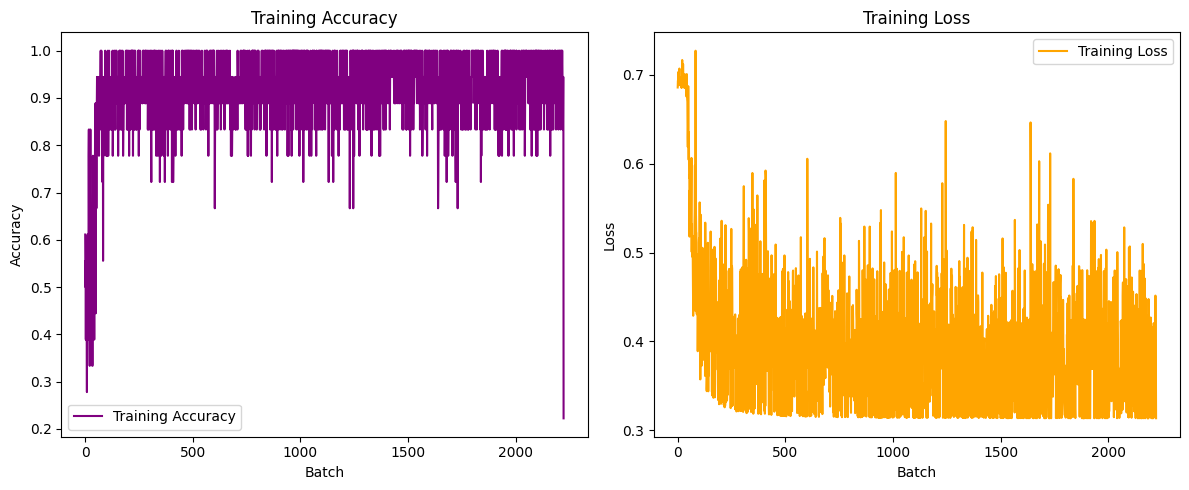

In [9]:
import matplotlib.pyplot as plt
# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
accuracies = [acc/18 for acc in training_accuracies]

# Plot training accuracies
axs[0].plot(accuracies, label='Training Accuracy', color="purple")
axs[0].set_title('Training Accuracy')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot training losses
axs[1].plot(training_losses, label='Training Loss', color='orange')
axs[1].set_title('Training Loss')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

In [10]:
# Evaluate model on testing data
model.eval()
testing_accuracies = []
testing_losses=[]
num_steps=0
nb_tr_examples=0

with torch.no_grad():
  for index, data in enumerate(testing_loader):
    # Load batch
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
    targets = data['targets'].to(device, dtype = torch.long)

    # Predict using model
    outputs = model.forward(ids, mask, token_type_ids).squeeze()

    # Calculate testing loss
    testing_loss = loss_function(outputs, targets)
    testing_losses.append(testing_loss.item())

    # Calculate testing accuracy
    big_val, big_idx = torch.max(outputs.data, dim=1)
    testing_accuracies.append(calcuate_accuracy(big_idx, targets))

    num_steps += 1
    nb_tr_examples += targets.size(0)

    # Metrics per batch
    testing_loss_step = sum(testing_losses) / num_steps
    testing_accu_step = sum(testing_accuracies) / nb_tr_examples
    print(f"Epoch {i} => batch {index} => Testing Loss: {testing_loss_step} - Testing Accuracy: {testing_accu_step}")

Epoch 0 => batch 0 => Testing Loss: 0.3166668117046356 - Testing Accuracy: 1.0
Epoch 0 => batch 1 => Testing Loss: 0.34285418689250946 - Testing Accuracy: 0.9722222222222222
Epoch 0 => batch 2 => Testing Loss: 0.33754754066467285 - Testing Accuracy: 0.9814814814814815
Epoch 0 => batch 3 => Testing Loss: 0.3455032855272293 - Testing Accuracy: 0.9722222222222222
Epoch 0 => batch 4 => Testing Loss: 0.341261625289917 - Testing Accuracy: 0.9777777777777777
Epoch 0 => batch 5 => Testing Loss: 0.3528665055831273 - Testing Accuracy: 0.9629629629629629
Epoch 0 => batch 6 => Testing Loss: 0.3507919268948691 - Testing Accuracy: 0.9603174603174603
Epoch 0 => batch 7 => Testing Loss: 0.34657491371035576 - Testing Accuracy: 0.9652777777777778
Epoch 0 => batch 8 => Testing Loss: 0.3579597506258223 - Testing Accuracy: 0.9506172839506173
Epoch 0 => batch 9 => Testing Loss: 0.3590544372797012 - Testing Accuracy: 0.95
Epoch 0 => batch 10 => Testing Loss: 0.3549212596633218 - Testing Accuracy: 0.954545454

Average Accuracies: 0.9435451638689049 - Average Losses: 0.3670459689317847



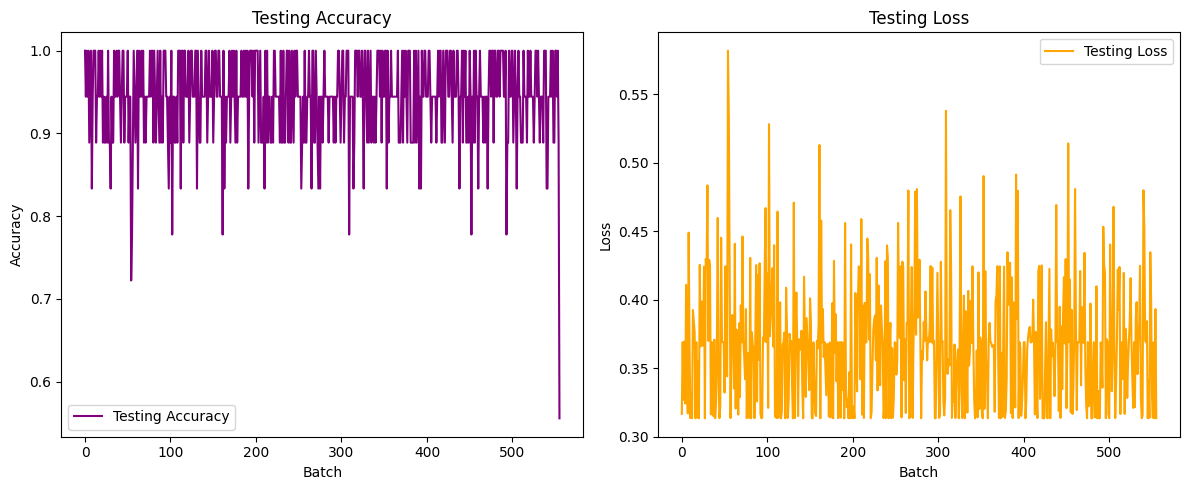

In [24]:
import matplotlib.pyplot as plt
import numpy as np


# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
test_accuracies = [acc/18 for acc in testing_accuracies]

# Print average results
print(f"Average Accuracies: {np.mean(test_accuracies)} - Average Losses: {np.mean(testing_losses)}\n")

# Plot testing accuracies
axs[0].plot(test_accuracies, label='Testing Accuracy', color="purple")
axs[0].set_title('Testing Accuracy')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot testing losses
axs[1].plot(testing_losses, label='Testing Loss', color='orange')
axs[1].set_title('Testing Loss')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

In [18]:
torch.save(model, "drive/MyDrive/Colab Notebooks/RoBERTa_GRU_2.pth")
tokenizer.save_pretrained("drive/MyDrive/Colab Notebooks/RoBERTa_Pretrained.pth")
tokenizer.save_vocabulary("drive/MyDrive/Colab Notebooks")

('drive/MyDrive/Colab Notebooks/vocab.json',
 'drive/MyDrive/Colab Notebooks/merges.txt')